# Stem & Tokenize


In [23]:
import numpy as np
import pandas as pd
import nltk
from bs4 import BeautifulSoup
import re
import os
import codecs
from sklearn import feature_extraction
import scipy as sp

In [2]:
df = pd.read_csv("../Cleaning/opioid_tweets_clean.csv")

In [3]:
# load nltk's English stopwords as variable called 'stopwords'
stopwords = nltk.corpus.stopwords.words('english')

# load nltk's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [4]:
# here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation, urls)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [5]:
totalvocab_stemmed = [] # List of the stemmed words
totalvocab_tokenized = [] #List of the tokenized words
for i in df["content"].values.astype("U"):
    allwords_stemmed = tokenize_and_stem(i)
    totalvocab_stemmed.extend(allwords_stemmed)
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [6]:
totalvocab_stemmed[1]
print( len(totalvocab_stemmed), len(totalvocab_tokenized))

664382 664382


In [7]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [9]:
def clean_string(string):
    # remove @user
    temp = re.sub(r'@(\w+)','', string) # clearly we do not wish to look at the user name.
        # remove links
    temp = re.sub(r'https://[a-zA-Z0-9\\./]+\s*','', temp) # had to modify this portion from Brenans, as his didn't clear http 
     # remove non-letters
    temp = re.sub("[^a-zA-Z]"," ", temp) # Will get rid of hashtags, $, etc.
        # remove multiple spaces
    temp = re.sub(r'\s\s+', ' ', temp) 
        # remove anything that is less than two characters
    temp = re.sub(r'\b\w{1,2}\b','',temp) # s will be an 'important character' if we do not include this
    # I am assuming that is because s is not a stopword in nltk. we could adjust by getting ride of any single character
    return temp

content_clean = []
for i in df["content"].values.astype("U"):
    content_clean.append(clean_string(i))

With a low min_df 'codein crazi' is a reference to the artist "Future", and might produce too much noise. Consider raising the df or adding it to the stop words. 

In [10]:
tfidf_vectorizer = TfidfVectorizer(max_df=.9, max_features=200000,
                                 min_df = 1, stop_words= 'english' ,
                                 use_idf=True, tokenizer=tokenize_and_stem,
                                   strip_accents = "unicode", lowercase = True )
 
%time tfidf_matrix = tfidf_vectorizer.fit_transform(content_clean)
#The warning message is present, despite adding strip_accent, in addition I believe I should add a preprocess
#stop words from nltk. Setting stop_words = 'english' uses sklearn's stopwords

print(tfidf_matrix.shape) #using min_df = .1, returns size of (42936, 4)

C:\Users\JungleBook\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Wall time: 34.3 s
(42936, 20091)


In [11]:
from sklearn.externals import joblib
joblib.dump(tfidf_matrix, 'tfidf_matrix.pkl')

C:\Users\JungleBook\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


['tfidf_matrix.pkl']

In [12]:
terms = tfidf_vectorizer.get_feature_names()
print(terms[100:110]) # Whether we use sklean, or nltk stopwords, we will end up with 'like'. I am very suprised this is not 
# a stop word.

['accent', 'accentu', 'accept', 'access', 'accessori', 'accesswir', 'acci', 'accid', 'accident', 'acclimatis']


In [13]:
vocabdic = tfidf_vectorizer.vocabulary_ #Is dictonary of our terms
#print(vocabdic) # finna be usefull

Some terms are too vague, perhaps we could add those to the  stop words and find the next m tweets that will lead to illicit drugs. The bad tweets document showed that (purchase, buy) where common in tweets selling drugs. 

In [14]:
tfidf_matrix.shape

(42936, 20091)

In [15]:
# Distance between tweets are calculated
from sklearn.metrics.pairwise import cosine_similarity
#dist = 1 - cosine_similarity(tfidf_matrix)

Basically, each tweet is compared to each other, forming a matrix with(num_tweets, num_tweets) shape.

In [16]:
print(dist.shape) 
num_tweets = dist.shape[0]

NameError: name 'dist' is not defined

Comparing one tweet to itself will, as expected, return a distance of 0 (or practically small enough to be zero).

In [ ]:
dist[5][5] # Distance between tweet 5 and tweet 5

In [ ]:
dist[5][54] # Distance between tweet 5 and tweet 54

## Example using a Nearest-Neighbors-like approach to sniff out bad tweets

First, we have a known illegal tweet serving as an archetypical "bad tweet".

In [ ]:
# Some tweets, like 584417, @ high profile celebrities
# Probably so when a fan is looking at the celeb mentions, they see the tweet
# Maybe a counter-argument to removing all @ signs
"""
Tough calls:
    383147
    Does an account called adspostinghere that happens to host an ad selling codeine count?
    
    
"""
target_id = '584417'
df[df["id"] == target_id]["content"]

In [ ]:
ix = df.index[df["id"] == target_id].tolist()[0]
content_clean[ix]

In [ ]:
sorted_scores = []
for i in range(num_tweets):
    sorted_scores.append((i, dist[ix][i]))

In [ ]:
sorted_scores = sorted(sorted_scores, key = lambda x: x[1])
sorted_scores[:10]

In [ ]:
sorted_scores = [x[0] for x in sorted_scores]

In [ ]:
# Load up existing bad tweets
with open("../bad_tweets.txt", "r") as f:
    bad_ids = [i.strip() for i in f.read().split("\n")]

In [ ]:
for x in sorted_scores[:100]:
    if df.iloc[x]["id"] not in bad_ids:
        print(content_clean[x])
        print("TWEET ID:")
        print(df.iloc[x]["id"])
        print()

# K - Means

In [17]:
# TESTING FOR THE OPTIMAL NUMBER OF K CLUSTERS FOR THE KMEANS MODEL
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sea

In [18]:
wcss =[] # Within cluster sum of squares
for i in range(1, 10):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(tfidf_matrix)
    wcss.append(kmeans.inertia_)

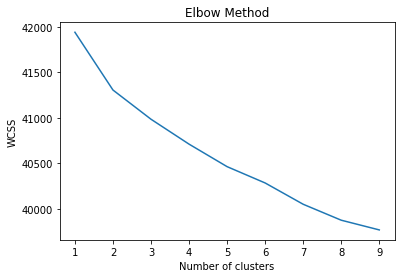

In [19]:
%matplotlib inline
plt.plot(range(1, 10), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show() # showing plot from a prior tfidf

Looks like the optimal number would is the number of terms we have from tfidf. Brenden worked his plot using .score(). I would consider doing it his was to find the correct amount of clusters. 

### BIC method for determining K 

In [20]:
from sklearn.mixture import GaussianMixture

The BIC metods works by treating each blob of data as multiple datasets with seperate means and variances. From there determining the mean and vairance. Giving us a BIC score that will tell us the amount of cluster is best. 

In [24]:
X = sp.sparse.csr_matrix.toarray(tfidf_matrix)

In [26]:
gm_bic= []
gm_score=[]
for i in range(1,4):
    gm = GaussianMixture(n_components=i,n_init=10,tol=1e-3,max_iter=1000).fit(X)
    print("BIC for number of cluster(s) {}: {}".format(i,gm.bic(X)))
    print("Log-likelihood score for number of cluster(s) {}: {}".format(i,gm.score(X)))
    print("-"*100)
    gm_bic.append(-gm.bic(X))
    gm_score.append(gm.score(X))

MemoryError: Unable to allocate 6.43 GiB for an array with shape (42936, 20091) and data type float64

So my method only works for smaller data sets or great computers

### K -Clusters

In [ ]:
from sklearn.cluster import KMeans

num_clusters = 9 #using num clusters from a prior term list.

km = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist() # The cluster is simply an array of non-negative integers 


In [ ]:
from sklearn.externals import joblib

joblib.dump(km,  'doc_cluster.pkl') # saves results for km as a pickle document
km = joblib.load('doc_cluster.pkl') 
clusters = km.labels_.tolist() # Tells you what word, belongs to what group


In [ ]:
data = { 'clusters' : clusters, 'words': content_clean }
frame = pd.DataFrame( data , index = [clusters] , columns = [ 'words' , 'clusters'] )
#created a frame than can classify the rows clean rows of df['content']

In [ ]:
frame['clusters'].value_counts() #This tell you what each string, in df['content'] belongs to. 

In [ ]:
from __future__ import print_function

print("Top terms per cluster:")
print()
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    for ind in order_centroids[i, :9]:
        print(' %s' % vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print()

# Multidimensional Scaling